### Maximize Utility for Quantum Entanglement Switch 

In this tutorial, we reproduce parts of the analytical results of [Vardoyan et al., 2023](https://ieeexplore.ieee.org/abstract/document/10313675) and compare them to our simplest simulation setup `surrogate_vardoyan_netsquid_comparison.py`. 

<img src="Images/users-server-topology.png" width="500" height="300">

A four-node, three-link topology, where user-server pairs wish to communicate. 

Settings:
- Attempt rate T = 10−3 s. 
- Links 1 and 2: 2 km long
- Link 3: varied.
- Buffer size B is unlimited for all users


First, we solve the analytical problem (defined in detail in [Vardoyan et al., 2023](https://ieeexplore.ieee.org/abstract/document/10313675)).

BUT BEFORE WE START, download [TU4LINK] and set the folder path to

`folder = /path/to/QENTSUR-DATA/quantum_entanglement_switch/notebook_qswitch_vardoyan/`

In [12]:
folder = '/Users/localadmin/Documents/git/surdata/QENTSUR-DATA/quantum_entanglement_switch/notebook_qswitch_vardoyan/'

In [13]:
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import pickle

font = 20
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font
})

beta = 0.2 # attenuation in fiber
c_loss = 1 # other system losses

attempt_durations_l = [10 ** -3, 10 ** -3] # [s]

def Fidel(w):
    return (3*w+1)/4 

def D_H(w1,w2):
    F = Fidel(w1*w2)
    return 1 + F*np.log2(F) + (1-F) * np.log2((1-F)/3) if F > 0.81 else 1e-10 # yield of the so-called “hashing” protocol

def U_D(R, w1, w2): 
    val = np.log(R*D_H(w1,w2))
    return val

def Objective(x):
    R, w1, w2 = x
    return - 2*U_D(R, w1, w2) + (2*R - d_l[0]*(1-w1))**2 + (R - d_l[1]*(1-w2))**2 

res = {'Distance [km]':[], 'Server link':[], 'User link':[], 'Utility':[], 'Rate':[], 'Fidelity':[]}
for i in [1.5**k for k in np.linspace(1,11.5,15)]:
    distances_l = [i, 2] # [km]

    eta_l = 10 ** (-0.1 * beta * np.array(distances_l)/2) # transmissivity between one link end and midpoint station
    d_l = 3 * c_loss * eta_l / (2*np.array(attempt_durations_l))

    sol = minimize(Objective, x0=(75, 0.95, 0.95), bounds=( (1,80), (0.85,1.), (0.85,1.)), method='L-BFGS-B')
    rate, ws, wu = sol.x
    U = U_D(rate, ws, wu)

    res['Server link'].append(Fidel(ws))
    res['User link'].append(Fidel(wu))
    res['Utility'].append(2*U) # aggregated utility (two users)
    res['Fidelity'].append(Fidel(ws*wu))
    res['Rate'].append(rate) 
    res['Distance [km]'].append(i) 
df_res = pd.DataFrame.from_records(res)
df_plot = df_res.melt(id_vars=['Distance [km]', 'Fidelity', 'Rate', 'Utility'], var_name='Type', value_name='Link Fidelity')


Let's look at the analytical results:

In [14]:
df_plot

,Distance [km],Fidelity,Rate,Utility,Type,Link Fidelity
0,1.500000,0.911134,58.608797,6.437373,Server link,0.939335
1,2.033105,0.911193,58.085289,6.420805,Server link,0.939134
2,2.755676,0.911152,57.460831,6.398237,Server link,0.938778
3,3.735051,0.911167,56.573494,6.367445,Server link,0.938349
4,5.062500,0.911186,55.382196,6.325340,Server link,0.937774
5,6.861728,0.911215,53.788717,6.267602,Server link,0.937008
6,9.300406,0.911270,51.659911,6.188135,Server link,0.936007
7,12.605799,0.911308,48.877861,6.078277,Server link,0.934666
8,17.085938,0.911386,45.243593,5.925559,Server link,0.932953
9,23.158331,0.911502,40.605942,5.711949,Server link,0.930797


Great, now we are ready to run the surrogate optimization applied to the qswitch setup in [NetSquid](https://netsquid.org). In order to run the qswitch simulation in NetSquid, you need to install `netsquid==0.10.3` and the [qswitch snippet](https://github.com/Luisenden/netsquid-qswitch), `version 1.1.1`. 

Then execute `python surrogate_vardoyan_netsquid_comparison.py --serverdist <distance> --iterator 100` (~3h runtime)

Alternatively, you can retrieve the result data from our public data storage [LINK] and set the folders as suggested above.

In [15]:
dfs = []
for name in glob.glob(folder + 'Vardoyan*.csv'):
    with open(name,'rb') as file: dfs.append(pd.read_csv(name, index_col=0))

df = pd.concat(dfs, ignore_index=True)
df

,bright_state_server,bright_state_user,Iteration,Fidelity,Fidelity_std,Rate,Rate_std,Utility,Utility_std,server_distance
0,0.065185,0.026565,95,0.910559,1.477676e-16,48.931,2.661619,6.060123,0.077129,12
1,0.069904,0.018523,64,0.913300,3.113087e-16,32.199,2.147388,5.284836,0.094202,34
2,0.075506,0.015531,72,0.910527,9.695355e-17,27.026,2.103482,4.869075,0.110295,45
3,0.079948,0.012765,51,0.908648,2.271502e-16,22.224,1.942240,4.432102,0.123879,56
4,0.080999,0.010502,52,0.909633,2.068655e-16,17.626,1.767798,3.989118,0.143779,67
5,0.081790,0.006951,62,0.912016,1.352847e-16,10.925,1.342797,3.082058,0.175737,89
6,0.076424,0.008365,94,0.916063,2.708191e-16,13.149,1.550061,3.546343,0.167271,78
7,0.085659,0.005650,31,0.909337,1.382174e-16,8.880,1.294092,2.599032,0.208176,100
8,0.058970,0.031958,28,0.911585,3.037174e-16,57.651,3.013305,6.412130,0.074166,1
9,0.068345,0.022816,99,0.910918,0.000000e+00,40.323,2.453578,5.680732,0.085466,23


**Visualization:** Plot utility, link-level fidelities (=solutions), rate and fidelity of end-to-end links

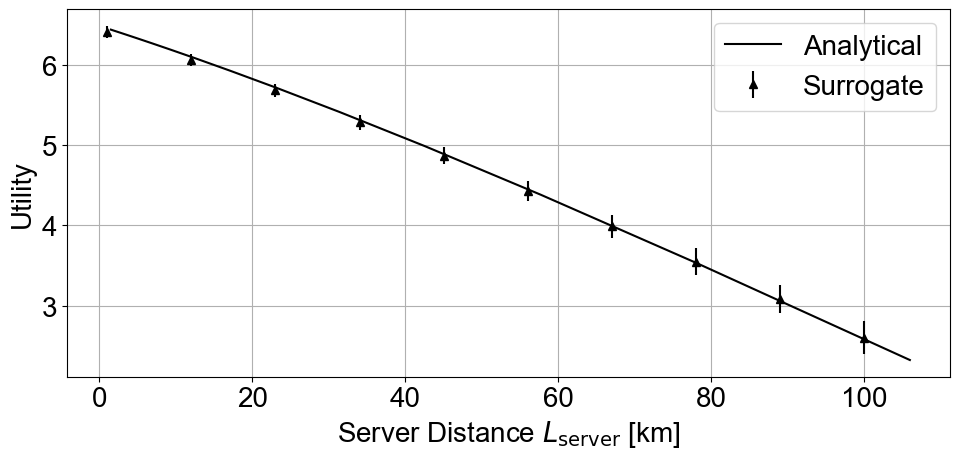

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
grouped= df.groupby('server_distance')
plt.plot(df_res['Distance [km]'], df_res['Utility'], color='black', label='Analytical')
plt.errorbar(df.server_distance, df.Utility, yerr=df.Utility_std,  fmt='^', color='black', label='Surrogate')
plt.grid()
plt.ylabel('Utility')
plt.xlabel(r'Server Distance $L_{\mathrm{server}}$ [km]')
plt.legend()
plt.tight_layout()
plt.savefig('Images/QES-example1-utility.pdf')

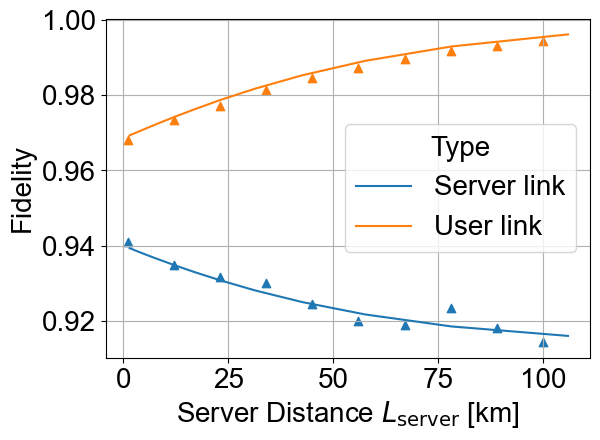

In [17]:
plt.scatter(df.server_distance, 1-df.bright_state_user, marker='^', color='tab:orange')
plt.scatter(df.server_distance, 1-df.bright_state_server, marker='^', color='tab:blue')
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')
plt.xlabel(r'Server Distance $L_{\mathrm{server}}$ [km]')
plt.ylabel('Fidelity')
plt.grid()
plt.tight_layout()
plt.savefig('Images/QES-example1-LinkFidelity.pdf')

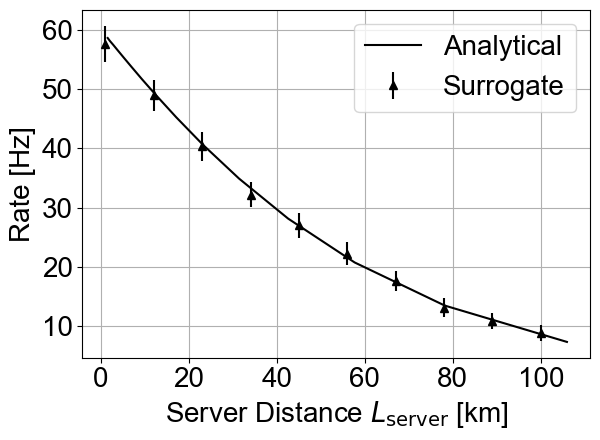

In [18]:
fig, ax1 = plt.subplots()
plt.errorbar(df.server_distance, df.Rate, yerr=df.Rate_std,  fmt='^', color='black', label= 'Surrogate')
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True, color='black', ax=ax1, label= 'Analytical')
plt.xlabel(r'Server Distance $L_{\mathrm{server}}$ [km]')
plt.ylabel('Rate [Hz]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Images/QES-example1-Rate.pdf')

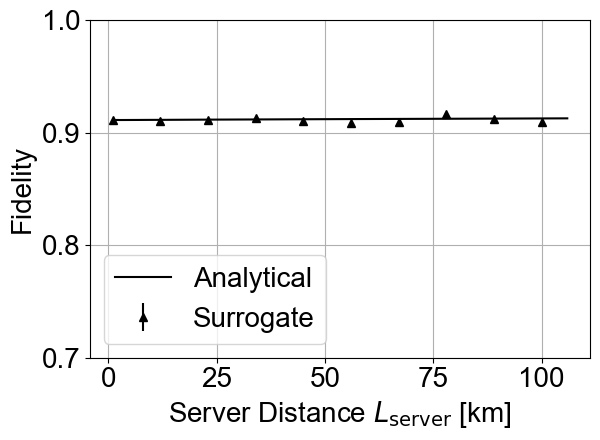

In [19]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True, color='black',label= 'Analytical' )
plt.errorbar(df.server_distance, df.Fidelity, yerr=df.Fidelity_std,  fmt='^', color='black', label= 'Surrogate')
plt.ylim([0.7,1])
plt.grid()
plt.xlabel(r'Server Distance $L_{\mathrm{server}}$ [km]')
plt.legend()
plt.tight_layout()
plt.savefig('Images/QES-example1-Fidelity.pdf')

**Werner states $\rho_w$ are equivalent to how we model depolarization in simulation $\rho_{depol}$:**
$$\rho_{B00} = |\Psi^+><\Psi^+|$$
$$ \rho_w  = w \rho_{B00} + (1-w) \frac{I_4}{4}$$

$$\rho_{depol} = (1-\frac{3}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$ 
$$\rho_{depol} = (1-\frac{3}{4}p + \frac{1}{4}p - \frac{1}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)I\rho_{B00}I + \frac{p}{4}(I\rho_{B00}I + X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)\rho_{B00} + \frac{p}{4}I$$
$$\rightarrow w = 1-p$$

Thus, we need to set the probability of an error happening to 
$$F = \frac{3w+1}{4} = 1-\alpha$$
$$\rightarrow w = 1 - \frac{4}{3}\alpha $$
$$\rightarrow p = 4/3\alpha $$

in our depolarization-error model in fiber (take a look at`netsquid_error_model.py`). 